### Setttings and modules

In [1]:
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
from scipy import optimize
import sympy


In [2]:
# matplotlib settings
fit_style = dict(linestyle="-", color="darkgreen", linewidth=1)
marker_style = dict(linestyle="", marker="o", markersize=7, markerfacecolor="mediumblue",
                    markeredgewidth=1, markeredgecolor="firebrick")
error_style = dict(ecolor="red", elinewidth=2, capsize=5)

font_style = {'family' : 'Arial',
              'weight' : 'normal',
              'size'   : 15}
matplotlib.rc("font", **font_style)

In [3]:
# path to data
path_data = "../data/"
path_thickness_variation = path_data + "measurements/"

In [4]:
def get_chi_squared(exp, obs, error, fit_params):
    dof = exp.size - fit_params
    chi_sq = np.sum(((obs - exp) / error) ** 2) / dof
    return chi_sq, (1 - stats.chi2.cdf(chi_sq, dof))

### Thickness variation

In [5]:
file_names = os.listdir(path_thickness_variation)
ampl = np.zeros(len(file_names))
ampl_error = np.zeros(len(file_names))

for i, file in enumerate(file_names):
    counts = np.loadtxt(path_thickness_variation + file, skiprows=1, comments="<", dtype=int)
    zInf = np.average(counts[:counts.size//4])
    z0 = np.average(np.sort(counts)[:3])
    zInf_error = np.std(counts[:counts.size//4])
    z0_error = np.std(np.sort(counts)[:3])
    ampl[i] = (zInf - z0) / zInf
    ampl_error[i] = np.sqrt((z0_error / zInf) ** 2 + (z0 * zInf_error / (zInf ** 2)) ** 2)

f_a = 0.2009854486679279 +- 0.0032829136233326144
f_s = 0.6735579390732193 +- 0.006015187881027175
chi^2 = 2.4881930619312578 , p-val = 0.6467512489077687


PermissionError: [Errno 13] Permission denied: 'thickness_variation_amplitude.pdf'

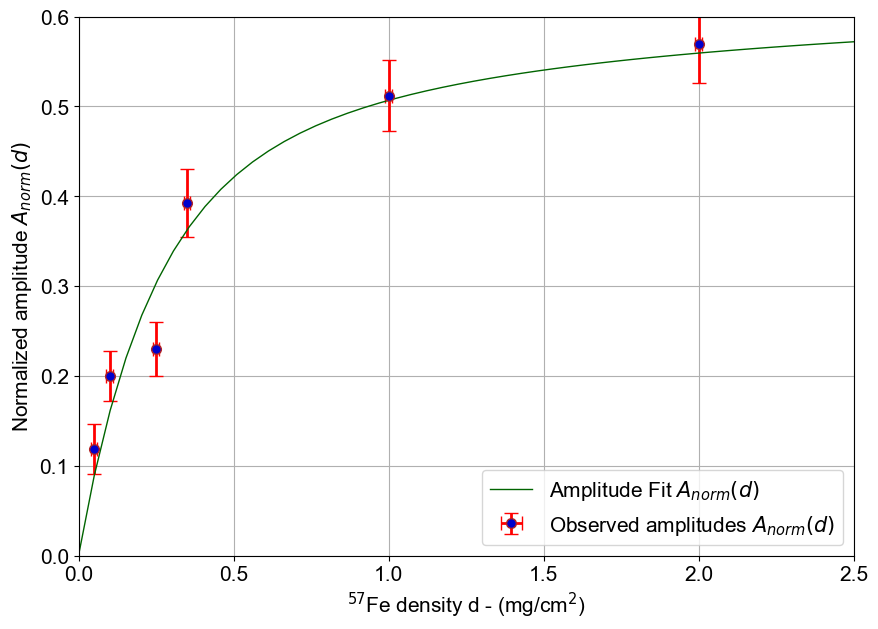

In [8]:
def amplitude(d, fS, fA):
    T = 0.606 * fA * d / 0.021
    return fS * (1 - np.exp(- T / 2) * np.i0(T / 2))

[d, gamma, gamma_err] = np.loadtxt(path_data + "dicke.txt").T
[fS, fA], cov = optimize.curve_fit(amplitude, d, ampl, sigma=ampl_error)

print("f_a =", fA, "+-", cov[1,1])
print("f_s =", fS, "+-", cov[0,0])
chi_2, p_val = get_chi_squared(amplitude(d, fS, fA), ampl, ampl_error, 2)
print("chi^2 =", chi_2, ", p-val =", p_val)

plt.figure(figsize=(10,7))
# we assume the density error to be +-0.01 mg/cm^2
d_error = np.full((6),0.01)
plt.errorbar(d, ampl, xerr=d_error, yerr=ampl_error,
             **marker_style, **error_style, label="Observed amplitudes $A_{norm}(d)$")
plt.plot(np.linspace(0,2.5), amplitude(np.linspace(0,2.5), fS, fA),
         **fit_style, label="Amplitude Fit $A_{norm}(d)$")

plt.xlabel("$^{57}$Fe density d - (mg/cm$^2$)")
plt.xlim(0, 2.5)
plt.ylabel("Normalized amplitude $A_{norm}(d)$")
plt.ylim(0, 0.6)

plt.legend(fancybox=True,loc="lower right")
plt.grid()
plt.savefig('thickness_variation_amplitude.pdf', pad_inches=0.1, bbox_inches="tight")
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\G'
<>:18: SyntaxWarning: invalid escape sequence '\G'
<>:22: SyntaxWarning: invalid escape sequence '\G'
<>:16: SyntaxWarning: invalid escape sequence '\G'
<>:18: SyntaxWarning: invalid escape sequence '\G'
<>:22: SyntaxWarning: invalid escape sequence '\G'
C:\Users\LInus\AppData\Local\Temp\ipykernel_7712\3903779128.py:16: SyntaxWarning: invalid escape sequence '\G'
  **marker_style, **error_style, label="Linewidths $\Gamma_{m}(d, f_A)$")
C:\Users\LInus\AppData\Local\Temp\ipykernel_7712\3903779128.py:18: SyntaxWarning: invalid escape sequence '\G'
  **fit_style, label="Linewidth Fit for $\Gamma_{m}(d)$")
C:\Users\LInus\AppData\Local\Temp\ipykernel_7712\3903779128.py:22: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel("Observed linewidth $\Gamma_{m}(d)$ (mm/s)")


Gamma0 =  3.024043300715482e-09 +- 1.4423099905525296e-14
fA =  1.858359197221516 +- 0.0008534158676962846
chi^2 = 0.0013336428784412578 , p-val = 0.970868468770659
T values:  [  2.68134684   5.36269368  13.40673421  18.76942789  53.62693683
 107.25387367]


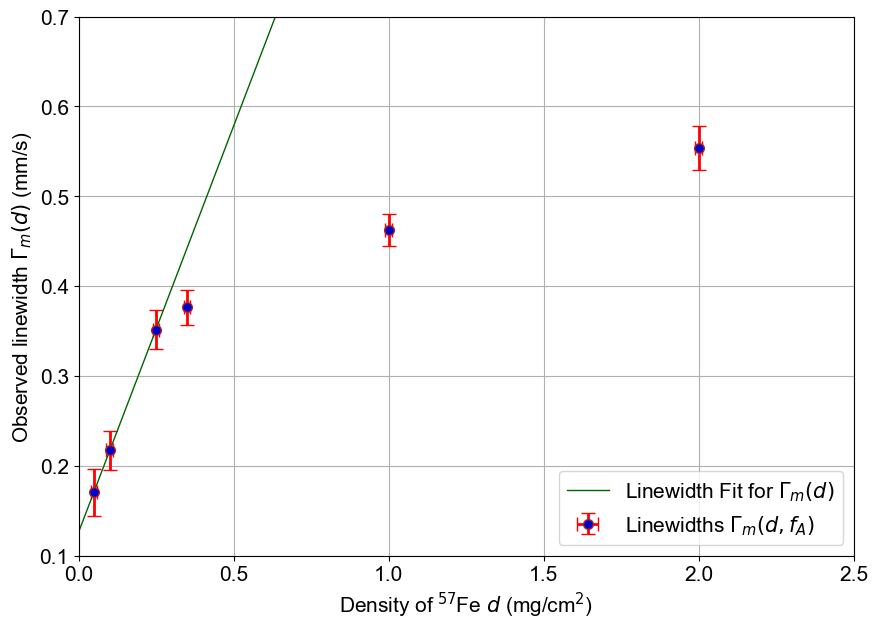

In [11]:
def gamma_gem(d, gamma0, fA):
    T = 0.606 * fA * d / 0.021
    return 2 * gamma0 * ( 1 + 0.134 * T)

end = -3
[gamma0, fA], cov = optimize.curve_fit(gamma_gem, d[:end], gamma[:end])
print("Gamma0 = ", gamma0 * 4.8077e-8, "+-", cov[0,0] * 4.8077e-8)
print("fA = ", fA, "+-", cov[1,1])
chi_2, p_val = get_chi_squared(gamma_gem(d[:end], gamma0, fA), gamma[:end], ampl_error[:end], 2)
print("chi^2 =", chi_2, ", p-val =", p_val)
print("T values: ", 0.606 * fA * d / 0.021)
plt.figure(figsize=(10,7))
# we assume the density error to be +-0.01 mg/cm^2
d_error = np.full((6),0.01)
plt.errorbar(d, gamma, xerr=d_error, yerr=gamma_err,
             **marker_style, **error_style, label="Linewidths $\Gamma_{m}(d, f_A)$")
plt.plot(np.linspace(0,2.5), gamma_gem(np.linspace(0,2.5), gamma0, fA),
         **fit_style, label="Linewidth Fit for $\Gamma_{m}(d)$")

plt.xlabel("Density of $^{57}$Fe $d$ (mg/cm$^2$)")
plt.xlim(0, 2.5)
plt.ylabel("Observed linewidth $\Gamma_{m}(d)$ (mm/s)")
plt.ylim(0.1, 0.7)

plt.legend(fancybox=True,loc="lower right")
plt.grid()
plt.savefig('thickness_variation_linfit.pdf', pad_inches=0.1, bbox_inches="tight")
plt.show()